In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%load_ext lab_black
#
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as units
import pickle

#
plt.style.use("mls_scf")

In [2]:
%autoreload 2
import dualpy as dp
import scipy.interpolate as interpolate

In [3]:
z = np.arange(100) * units.km
T = (
    200.0
    - (150.0 - 80.0 * z / (100.0 * units.km))
    * np.sin(z * units.rad / (15.0 * units.km))
) * units.K
T = dp.seed(T, "T", initial_type="dense")
angle_fine = np.linspace(0.001, 0.03, 2048) * units.rad

In [4]:
def one_calculation(T):
    radiance_in = z / (100.0 * units.km)
    # radiance_in = T  # 20.0 * np.log10(T / units.K)
    raw_angle_in = units.rad * (z / (3000.0 * units.km))
    refraction_correction = 0.001 * T / (300.0 * units.K) * units.rad
    angle_in = raw_angle_in + refraction_correction
    interpolator = dp.CubicSplineLinearJacobians(angle_in, radiance_in)
    diagnostics = (angle_in, radiance_in, refraction_correction)
    return interpolator(angle_fine), diagnostics

In [5]:
r_fine, (angle_in, radiance_in, refraction_correction) = one_calculation(T)

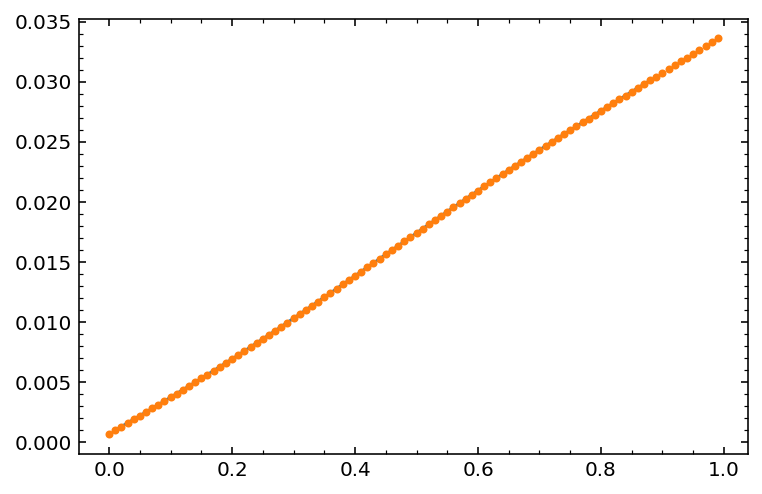

In [6]:
plt.plot(units.Quantity(r_fine), angle_fine)
plt.plot(units.Quantity(radiance_in), units.Quantity(angle_in), ".")
plt.show()

In [7]:
# i = interpolate.interp1d(angle_in, radiance_in, kind="linear")
# help(i)

In [8]:
r_ana, r_num = dp.compute_numeric_jacobians(
    lambda T: one_calculation(T)[0], (T,), include_all_jacobians=True
)

In [9]:
j_ana = r_ana.jacobians["T"].todensearray()
j_num = r_num.jacobians["T"].todensearray()
dj = j_ana - j_num

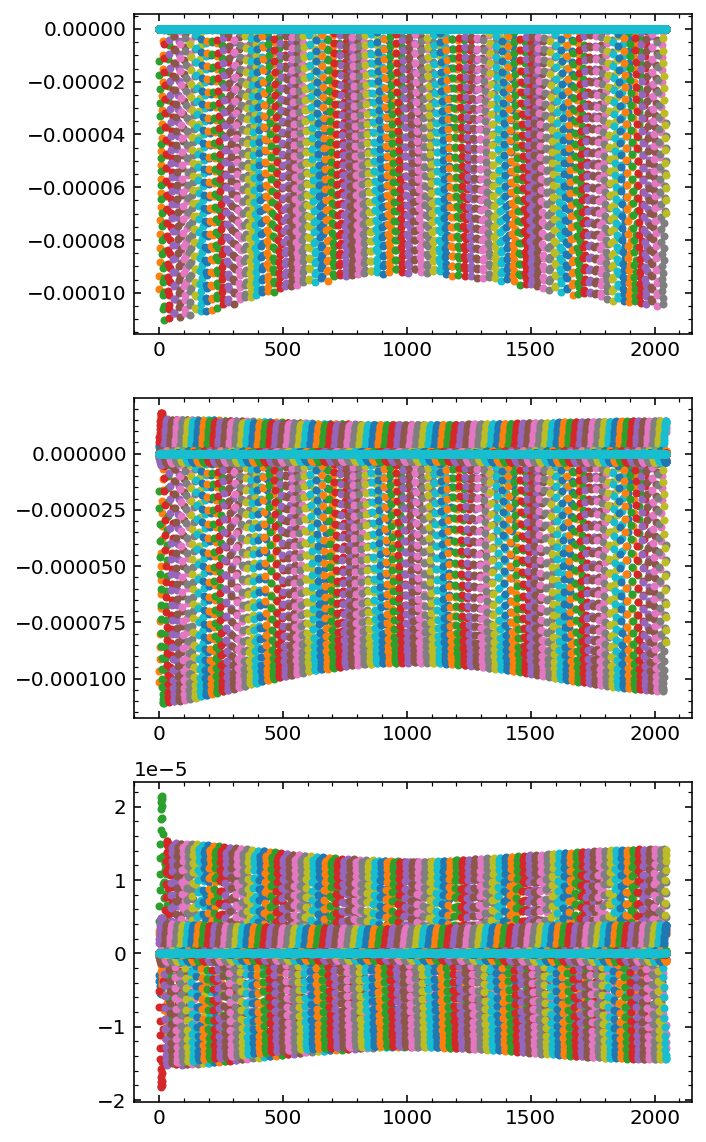

In [10]:
fig, ax = plt.subplots(3, figsize=[5, 10])
ax[0].plot(j_ana, ".")
ax[1].plot(j_num, ".")
ax[2].plot(dj, ".")
plt.show()

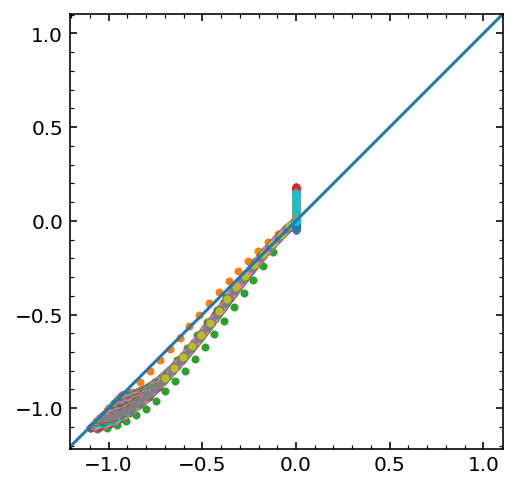

In [11]:
plt.plot(j_ana / 1e-4, j_num / 1e-4, ".")
plt.gca().set_aspect("equal", "box")
plt.gca().axline((0, 0), (1, 1))
# plt.xlim(-1.2, 0.2)
# plt.ylim(-1.2, 0.2)
plt.show()